# SIS Health Vector

Eignung für das Vorkommen und die saisonale Aktivität der Tigermücke (Aedes albopictus) in Europa

Dieses Skript verarbeitet den Datensatz **SIS Health Vector** aus dem Copernics Climate Data Store. Der Datensatz enthält Informationen zu der Eignung der Umweltbedingungen sowie der saisonalen Aktivität der Tigermücke. Der Datensatz wurde im Rahmen des C3S European Health Service entwickelt. Die Informationen sind für unterschiedliche zukünftige Zeiträume und Klimawandelszenarien verfügbar.

**Informationen zum Datensatz**: 

* Source: [SIS Health Vector](https://cds.climate.copernicus.eu/datasets/sis-health-vector?tab=overview)
* Author: T. Tewes (Stadt Konstanz) 
* Notebook-Version: 1.1 (Aktualisiert: März 10, 2025)

## 1. Festlegen der Pfade und Arbeitsverzeichnisse

In [1]:
import os

''' ---- Verzeichnisse hier angeben ---- '''
download_folder = r".\data\sis-health-vector\download"
working_folder = r".\data\sis-health-vector\working"
geotiff_folder = r".\data\sis-health-vector\geotiff"
csv_folder = r".\data\sis-health-vector\csv"
output_folder = r".\data\sis-health-vector\output"
''' ----- Ende der Angaben ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Herunterladen und Entpacken des Datensatzes

### 2.1 Authentifizierung

In [2]:
import cdsapi

def main():
    # API-Key für die Authentifizierung
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"

    # Erstellung des CDS-API-Clients
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Definieren die „request“ und laden Sie den Datensatz herunter

In [3]:
# Definieren der Begrenzungsrahmen-Koordinaten (WGS84-Format)
# Das Koordinatenformat lautet: [Norden, Westen, Süden, Osten]
bbox_wgs84_deutschland = [56.0, 5.8, 47.2, 15.0]
bbox_wgs84_de_standard = [5.7, 47.1, 15.2, 55.2]
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]
bbox_wgs84_konstanz_standard = [9.0, 47.6, 9.3, 47.8]  # [West, South, East, North]

# Alternativ können Sie ein Shapefile für eine präzise geografische Filterung verwenden
import geopandas as gpd
import math

# Beispiel: Shapefile von Konstanz laden (WGS84-Projektion)
de_shapefile = r"./shapefiles/de_boundary.shp"
de_gdf = gpd.read_file(de_shapefile)

# Extrahieren Sie den Begrenzungsrahmen des Shapefiles
de_bounds = de_gdf.total_bounds

# Passen Sie den Begrenzungsrahmen an und puffern Sie ihn, um einen etwas größeren
de_bounds_adjusted = [(math.floor(de_bounds[0]* 10)/10)-0.1,
                      (math.floor(de_bounds[1]* 10)/10)-0.1,
                      (math.ceil(de_bounds[2]* 10)/10)+0.1,
                      (math.ceil(de_bounds[3]* 10)/10)+0.1]

# Ordnen Sie die Koordinaten in das Format: [Nord, West, Süd, Ost] um.
bbox_de_bounds_adjusted = [de_bounds_adjusted[3], de_bounds_adjusted[0],
                           de_bounds_adjusted[1], de_bounds_adjusted[2]]

In [4]:
# Definition des Datensatzes und der Request-Parameter
dataset = "sis-health-vector"
request = {
    "variable": [
        "suitability",
        "season_length"
    ],
    "experiment": [
        "rcp4_5",
        "rcp8_5"
    ],
    "ensemble_statistic": [
        "ensemble_members_average",
        "ensemble_members_standard_deviation"
    ],
    "area": bbox_de_bounds_adjusted
}

In [5]:
# Führen Sie es aus, um den Datensatz herunterzuladen:
def main_retrieve():
    dataset_filename = f"{dataset}.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)

    # Den Datensatz nur herunterladen, wenn er noch nicht heruntergeladen wurde
    if not os.path.isfile(dataset_filepath):
        # Rufen Sie den CDS-Client nur auf, wenn der Datensatz noch nicht heruntergeladen wurde.
        client = main()
        # Den Datensatz mit den definierten Anforderungsparametern herunterladen
        client.retrieve(dataset, request, dataset_filepath)
    else:
        print("Datensatz bereits heruntergeladen.")

if __name__ == "__main__":
    main_retrieve()

Datensatz bereits heruntergeladen.


### 2.3 Extrahieren die ZIP-Datei in Ordner

In [6]:
import zipfile

# Definieren Sie einen Extraktionsordner für die ZIP-Datei, der dem Arbeitsordner entspricht
extract_folder = working_folder

# Entpacken der ZIP-Datei
try:   
    if not os.listdir(extract_folder):
        dataset_filename = f"{dataset}.zip"
        dataset_filepath = os.path.join(download_folder, dataset_filename)

        with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
            print(f"Dateien erfolgreich extrahiert nach: {extract_folder}")
    else:
        print("Ordner ist nicht leer. Entpacken überspringen.")
except FileNotFoundError:
    print(f"Fehler: Die Datei {dataset_filepath} wurde nicht gefunden.")
except zipfile.BadZipFile:
    print(f"Fehler: Die Datei {dataset_filepath} ist keine gültige ZIP-Datei.")
except Exception as e:
    print(f"Ein unerwarteter Fehler ist aufgetreten: {e}")

Ordner ist nicht leer. Entpacken überspringen.


## 3. Untersuchen der Metadaten der NetCDF4-Datei

### 3.1 Erstellen eines DataFrame mit verfügbaren NetCDF-Dateien

In [7]:
import re
import pandas as pd

def meta(filename):
    # Überprüfen, ob der Dateiname dem erwarteten Muster entspricht
    match = re.search(r'mosquito_(suit|seas)_(rcp\d{2})_(\w+)_v(\d+\.\d+)\.', filename)

    # Fehler ausgeben, wenn der Dateiname nicht dem erwarteten Schema entspricht
    if not match:
        match = re.search("Der angegebene Dateiname entspricht nicht dem erwarteten Benennungsschema.")
    
    # Metadaten als Dictionary zurückgeben
    var = match.group(1)
    return dict(
        filename=filename,
        path=os.path.join(working_folder, filename),
        variable=var,
        variable_name="season_length" if var == 'seas' else "suitability",
        rcp = match.group(2),
        rcp_statistic = match.group(3),
        # version = match.group(4),
    )

# Metadaten für alle NetCDF-Dateien im Ordner extrahieren
# Das Dictionary 'nc_files' enthält alle relevanten Metadaten der verfügbaren NetCDF4-Dateien
# Dieses Dictionary wird später verwendet, um die Dateien in GeoTiff zu konvertieren
nc_files = [meta(f) for f in os.listdir(extract_folder) if f.endswith('.nc')]
df_nc_files = pd.DataFrame.from_dict(nc_files)

# Pandas-Anzeigeoptionen anpassen
pd.options.display.max_colwidth = 24

# DataFrame anzeigen, ohne die Spalte 'path' darzustellen
df_nc_files.head(10).loc[:, df_nc_files.columns != 'path']

,filename,variable,variable_name,rcp,rcp_statistic
0,mosquito_seas_rcp45_...,seas,season_length,rcp45,mean
1,mosquito_seas_rcp45_...,seas,season_length,rcp45,stdev
2,mosquito_seas_rcp85_...,seas,season_length,rcp85,mean
3,mosquito_seas_rcp85_...,seas,season_length,rcp85,stdev
4,mosquito_suit_rcp45_...,suit,suitability,rcp45,mean
5,mosquito_suit_rcp45_...,suit,suitability,rcp45,stdev
6,mosquito_suit_rcp85_...,suit,suitability,rcp85,mean
7,mosquito_suit_rcp85_...,suit,suitability,rcp85,stdev


### 3.2 Einzigartige Variablennamen und verfügbare Variablen ausgeben

In [8]:
import netCDF4 as nc

# Variable definieren, um bereits verarbeitete Variablennamen zu speichern und Duplikate zu vermeiden  
seen_variables = set()

# Alle Variablen in jeder NetCDF-Datei auflisten  
for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    # Überspringen, wenn die Variable bereits verarbeitet wurde  
    if variable_name in seen_variables:
        continue

    # NetCDF-Datei im Lesemodus öffnen  
    with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:  
        # Alle Variablen im aktuellen Datensatz auflisten  
        variables_list = list(nc_dataset.variables.keys())  
        
        # Details der Datei und ihrer Variablen ausgeben  
        print(f"{i + 1:<2} {variable_name:<18}: Verfügbare Variablen: {variables_list}") 
    
    # Diese Variable als verarbeitet markieren  
    seen_variables.add(variable_name)

1  season_length     : Verfügbare Variablen: ['season_length', 'height', 'lat', 'lon', 'time']
5  suitability       : Verfügbare Variablen: ['suitability', 'height', 'lat', 'lon', 'time']


In [9]:
# Alle Variableninformationen in jeder NetCDF-Datei auflisten  
seen_variables = set()

# Alle variablen Informationen in jeder NetCDF-Datei auflisten
for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    # Überspringen, wenn die Variable bereits verarbeitet wurde
    if variable_name in seen_variables:
        continue
    
    # NetCDF-Datei im Lesemodus öffnen
    with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:  
        # Primärvariable-Daten abrufen  
        variable_data = nc_dataset[variable_name]  

        # Zusammenfassung der Primärvariable erstellen  
        summary = {  
            "Variablenname": variable_name,  
            "Datentyp": variable_data.dtype,  
            "Form": variable_data.shape,  
            "Variableninfo": f"{variable_data.dimensions}",  
            "Einheiten": getattr(variable_data, "units", "N/A"),  
            "Langer Name": getattr(variable_data, "long_name", "N/A"),  
        }  

        # Datensatz-Zusammenfassung als DataFrame zur besseren Visualisierung anzeigen  
        nc_summary = pd.DataFrame(list(summary.items()), columns=['Beschreibung', 'Bemerkungen'])  
        print(f"{i + 1}. Zusammenfassung der Variable '{variable_name}':")  
        display(nc_summary)  

    # Variablenname zur Liste der bereits verarbeiteten Variablen hinzufügen  
    seen_variables.add(variable_name)  

    # Ausgabe begrenzen  
    output_limit = 2  
    if len(seen_variables) >= output_limit:  
        print(f".... (Ausgabe auf die ersten {output_limit} Variablen gekürzt)")  
        break  

1. Zusammenfassung der Variable 'season_length':


,Beschreibung,Bemerkungen
0,Variablenname,season_length
1,Datentyp,float32
2,Form,"(100, 82, 95)"
3,Variableninfo,"('time', 'lat', 'lon')"
4,Einheiten,1
5,Langer Name,Ensemble members ave...


5. Zusammenfassung der Variable 'suitability':


,Beschreibung,Bemerkungen
0,Variablenname,suitability
1,Datentyp,float32
2,Form,"(100, 82, 95)"
3,Variableninfo,"('time', 'lat', 'lon')"
4,Einheiten,1
5,Langer Name,Ensemble members ave...


.... (Ausgabe auf die ersten 2 Variablen gekürzt)


## 4. Exportieren der NetCDF4-Dateien im CSV-Format

### 4.1 Definieren eine Funktion zum Konvertieren von NetCDF-Daten in DataFrame

In [10]:
import xarray as xr

# Funktion zur Konvertierung von NetCDF-Daten in ein Pandas DataFrame
def netcdf_to_dataframe(
    nc_file,
    bounding_box=None):

    # Öffne das NetCDF-Dataset im Lesemodus
    with xr.open_dataset(nc_file['path']) as nc_dataset:
        # Zugriff auf die Variablendaten aus dem Datensatz
        variable_data = nc_dataset[nc_file['variable_name']]

        # Sicherstellen, dass die Namen für Breiten- und Längengrad korrekt sind
        latitude_name = 'latitude' if 'latitude' in nc_dataset.coords else 'lat'
        longitude_name = 'longitude' if 'longitude' in nc_dataset.coords else 'lon'
        
        # Falls eine Begrenzungsbox angegeben ist, die Daten filtern
        if bounding_box:
            filtered_data = variable_data.where(
                (nc_dataset[latitude_name] >= bounding_box[1]) & (nc_dataset[latitude_name] <= bounding_box[3]) &
                (nc_dataset[longitude_name] >= bounding_box[0]) & (nc_dataset[longitude_name] <= bounding_box[2]),
                drop=True
            )
        else:
            filtered_data = variable_data
        
        # Umwandlung des xarray-Datensatzes in ein Pandas DataFrame
        df = filtered_data.to_dataframe().reset_index().set_index(['time', latitude_name, longitude_name])

        variable_column_name = f"{nc_file['variable_name']}_{nc_file['rcp']}_{nc_file['rcp_statistic']}"
        df.rename(columns={nc_file['variable_name']: variable_column_name}, inplace=True)

        # Entfernen nicht benötigter Spalten (variiert je nach Datensatz)
        if 'height' in df.columns:
            df = df.drop(columns=['height'])
        if 'quantile' in df.columns:
            df = df.drop(columns=['quantile'])

        return df

### 4.2 DataFrame erstellen und als CSV-Datei exportieren

In [11]:
# Alle netCDF4-Dateien in einzelne CSV-Dateien exportieren
for nc_file in nc_files:
    # CSV-Dateiname und Pfad für die Ausgabe definieren
    csv_filename = f"mosquito_{nc_file['variable']}_{nc_file['rcp']}_{nc_file['rcp_statistic']}.csv"
    csv_filepath = os.path.join(csv_folder, csv_filename)
    
    # Exportiere das DataFrame als CSV, falls es noch nicht existiert
    if not os.path.isfile(csv_filepath):
        dataframe = netcdf_to_dataframe(nc_file, bounding_box=None)
        dataframe.to_csv(csv_filepath)
    else:
        print(f"Datei existiert bereits unter {csv_filepath}.\nÜberspringen den Export.")
        csv_filename_latest = csv_filepath
        
        break

print("Letzte vorhandene CSV-Datei lesen...")
dataframe = pd.read_csv(csv_filepath).set_index(['time', 'lat', 'lon'])
        
# Ändere die Pandas-Anzeigeoptionen
pd.options.display.float_format = '{:,.2f}'.format

# Zeige das DataFrame an
dataframe

Datei existiert bereits unter .\data\sis-health-vector\csv\mosquito_seas_rcp45_mean.csv.
Überspringen den Export.
Letzte vorhandene CSV-Datei lesen...


season_length_rcp45_mean
time       lat   lon                            
1986-01-01 47.10 5.70                    137.85 
                 5.80                    134.25 
                 5.90                    127.43 
                 6.00                    118.44 
                 6.10                    103.06 
...                                         ... 
2085-01-01 55.20 14.70                   102.34 
                 14.80                    94.36 
                 14.90                    91.52 
                 15.00                    94.66 
                 15.10                   104.35 

[779000 rows x 1 columns]

### 4.3 DataFrame erstellen und als zusammengeführte CSV-Datei exportieren

In [12]:
from tqdm.notebook import tqdm
import textwrap

# CSV-Dateiname und Pfad für die Ausgabe definieren
csv_filename = 'sis-health-vector-merged.csv.zip'
csv_path = os.path.join(csv_folder, csv_filename)

# Exportieren Sie die NetCDF-Dateien als zusammengeführte CSV-Datei.
if not os.path.isfile(csv_path):
    dataframes = [netcdf_to_dataframe(nc_file) for nc_file in tqdm(nc_files)]
    df_merged = pd.concat(dataframes, axis=1)
    df_merged.to_csv(csv_path, sep=',', encoding='utf8', compression='zip')
else:
    print(f"Datei existiert bereits unter {csv_filepath}.\nÜberspringen den Export.")
    print("Lesen bestehende CSV-Datei ein...")
    df_merged = pd.read_csv(csv_path).set_index(['time', 'lat', 'lon'])
    
# Funktion zum Umbruch der Spaltennamen für bessere Lesbarkeit
def wrap_column_names(df, width):
    wrapped_columns = {col: " ".join(textwrap.wrap(col, width)) for col in df.columns}
    return df.rename(columns=wrapped_columns)
    
# Ändere die Pandas-Anzeigeoptionen
pd.options.display.float_format = '{:,.2f}'.format
    
# Zeige das DataFrame an
df_wrapped = wrap_column_names(df_merged, width=14)
df_wrapped

Datei existiert bereits unter .\data\sis-health-vector\csv\mosquito_seas_rcp45_mean.csv.
Überspringen den Export.
Lesen bestehende CSV-Datei ein...


season_length_ rcp45_mean  season_length_ rcp45_stdev  \
time       lat   lon                                                            
1986-01-01 47.10 5.70                    137.85                       8.88      
                 5.80                    134.25                       7.83      
                 5.90                    127.43                      10.29      
                 6.00                    118.44                      13.42      
                 6.10                    103.06                      13.96      
...                                         ...                        ...      
2085-01-01 55.20 14.70                   102.34                      20.69      
                 14.80                    94.36                      22.07      
                 14.90                    91.52                      21.24      
                 15.00                    94.66                      19.00      
                 15.10                   104.35                      17.06      

                        season_length_ rcp85_mean  season_length_ rcp85_stdev  \
time       lat   lon                                                            
1986-01-01 47.10 5.70                    137.85                       8.32      
                 5.80                    134.25                       8.09      
                 5.90                    127.43                       9.92      
                 6.00                    118.44                      11.70      
                 6.10                    103.06                      12.18      
...                                         ...                        ...      
2085-01-01 55.20 14.70                   135.23                      18.08      
                 14.80                   131.20                      20.02      
                 14.90                   128.82                      20.77      
                 15.00                   129.81                      19.47      
                 15.10                   138.60                      14.97      

                        suitability_rc p45_mean  suitability_rc p45_stdev  \
time       lat   lon                                                        
1986-01-01 47.10 5.70                     83.47                     2.55    
                 5.80                     80.93                     2.91    
                 5.90                     76.16                     3.28    
                 6.00                     69.44                     3.90    
                 6.10                     61.91                     3.89    
...                                         ...                      ...    
2085-01-01 55.20 14.70                    66.27                    10.68    
                 14.80                    63.85                    10.38    
                 14.90                    63.01                     8.24    
                 15.00                    65.55                     7.65    
                 15.10                    68.65                     7.68    

                        suitability_rc p85_mean  suitability_rc p85_stdev  
time       lat   lon                                                       
1986-01-01 47.10 5.70                     83.47                     2.63   
                 5.80                     80.93                     3.02   
                 5.90                     76.16                     3.11   
                 6.00                     69.44                     3.57   
                 6.10                     61.91                     3.53   
...                                         ...                      ...   
2085-01-01 55.20 14.70                    83.59                     9.20   
                 14.80                    81.74                     9.65   
                 14.90                    81.60                     8.25   
                 15.00                    83.25                     7.34   
  

## 5. Exportieren der NetCDF4-Datei nach GeoTIFF

### 5.1 Definieren eine Funktion zum Exportieren der NetCDF4-Datei als GeoTIFF-Datei(en)

In [13]:
import numpy as np
from rasterio.transform import from_origin
import rasterio

from tqdm.notebook import tqdm

def main_export_geotiff(
    nc_file,
    bounding_box=None,
    start_year=None,
    end_year=None,
    merged=None,
    output_directory=None):
    
    """
    Parameter:
        nc_file (dict): Ein Dictionary mit den Schlüsseln 'path' (Dateipfad), 'variable', 'rcp' und 'statistic'.
        bounding_box (list): [lon_min, lat_min, lon_max, lat_max] (optional).
        start_year (int): Startjahr für das Dataset (optional).
        end_year (int): Endjahr für das Dataset (optional).
        merged (bool): Gibt an, ob ein zusammengeführtes GeoTIFF oder einzelne GeoTIFFs erstellt werden sollen (optional).
        output_directory (str): Verzeichnis zum Speichern der Ausgabe-GeoTIFF-Dateien (optional).
    """

    # Öffnet die NetCDF-Datei
    with nc.Dataset(nc_file['path'], 'r') as nc_dataset:
        nc_dataset = nc.Dataset(nc_file['path'], 'r')
        lon = nc_dataset['lon'][:]
        lat = nc_dataset['lat'][:]
        
        # Falls eine Begrenzungsbox angegeben wurde, filtere die Daten entsprechend
        if bounding_box:
            lon_min, lat_min, lon_max, lat_max = bounding_box
            
            indices_lat = np.where((lat >= lat_min) & (lat <= lat_max))[0]
            indices_lon = np.where((lon >= lon_min) & (lon <= lon_max))[0]
            start_lat, end_lat = indices_lat[0], indices_lat[-1] + 1
            start_lon, end_lon = indices_lon[0], indices_lon[-1] + 1
        else:
            start_lat, end_lat = 0, len(lat)
            start_lon, end_lon = 0, len(lon)
        
        lat = lat[start_lat:end_lat]
        lon = lon[start_lon:end_lon]
        
        # Extrahiere die Zeitvariable und konvertiere sie in lesbare Datumsangaben
        time_var = nc_dataset.variables['time']
        time_units = time_var.units
        time_calendar = getattr(time_var, "calendar", "standard")
        cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
    
        # Berechnet die räumliche Auflösung und die Rastertransformation
        dx = abs(lon[1] - lon[0])
        dy = abs(lat[1] - lat[0])
        transform = from_origin(lon.min() - dx / 2, lat.min() - dy / 2, dx, -dy)
            
        # Bestimmt den verfügbaren Zeitraum
        min_year = cftime[0].year
        max_year = cftime[-1].year

        if start_year and end_year:
            # Passen Sie start_year und end_year basierend auf dem verfügbaren Zeitraum an
            if start_year < min_year:
                print(f"Das angegebene Startjahr {start_year} liegt vor dem Datensatzbereich.")
                print(f"Das Startjahr wird auf {min_year} angepasst.")
            if end_year > max_year:
                print(f"Das angegebene Endjahr {end_year} liegt nach dem Datensatzbereich.")
                print(f"Das Endjahr wird auf {max_year} angepasst.")

            start_year = max(start_year, min_year)
            end_year = min(end_year, max_year)
        else:
            # Standardmäßig wird der gesamte Datensatz verwendet
            start_year = min_year
            end_year = max_year

        # Findet die Indizes, die dem angegebenen Jahresbereich entsprechen
        start_index = next(i for i, dt in enumerate(cftime) if dt.year == start_year)
        end_index = next(i for i, dt in enumerate(cftime) if dt.year == end_year) + 1  # Full year (monthly data)
        
        # Extrahiere Variablen-Daten
        variable_data = nc_dataset.variables[nc_file['variable_name']]
        variable_data_subset = variable_data[start_index:end_index, start_lat:end_lat, start_lon:end_lon]
        
        # nc_filename-Präfix erstellen
        nc_filename_prefix = f"mosquito_{nc_file['variable_name']}_{nc_file['rcp']}_{nc_file['rcp_statistic']}"
    
        if merged:
            # Erstellt ein zusammengeführtes GeoTIFF mit allen Zeitscheiben als separate Bänder
            if output_directory:
                subset_directory_path = output_directory
            else:
                subset_directory_path = os.path.join(geotiff_folder, f"{dataset}_merged")
                os.makedirs(subset_directory_path, exist_ok=True)
            
            # Pfad der Ausgabedatei festlegen
            output_filename = f"{nc_filename_prefix}-merged-{start_year}-{end_year}.tif"
            output_filepath = os.path.join(subset_directory_path, output_filename)

            # Erstellt eine GeoTIFF-Datei mit mehreren Bändern für jede Zeitscheibe
            with rasterio.open(
                output_filepath,
                "w",
                driver = "GTiff",
                dtype = str(variable_data_subset.dtype),
                width = variable_data_subset.shape[2],
                height = variable_data_subset.shape[1],
                count = variable_data_subset.shape[0],
                crs = "EPSG:4326",
                nodata = -9999,
                transform=transform,        
            ) as dst:
                for year_index in tqdm(range(variable_data_subset.shape[0]),
                                    desc=f"Exportiere zusammengeführte GeoTIFF-Datei von {start_year} bis {end_year}"):
                    band_data = variable_data_subset[year_index,:,:]
                    dt = cftime[start_index + year_index]
                    band_desc = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"
                    
                    # Schreibe jede Jahresscheibe als Band
                    dst.write(band_data, year_index + 1)
                    dst.set_band_description(year_index + 1, band_desc)

        else:
            # Export als einzelne GeoTIFF-Dateien
            if output_directory:
                subset_directory_path = output_directory
            else:
                subset_directory_path = os.path.join(geotiff_folder, f"{dataset}_individual")
                os.makedirs(subset_directory_path, exist_ok=True)
            
            for year_index in tqdm(range(variable_data_subset.shape[0]),
                                desc="Exportieren einzelner GeoTIFF-Dateien"):
                # Bestimmt das Datum für die aktuelle Zeitscheibe
                dt = cftime[start_index + year_index]
                dt_full = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"

                # Definiert den Speicherort der Ausgabe-GeoTIFF-Datei            
                output_filename = f"{nc_filename_prefix}_{dt_full}.tif"
                output_filepath = os.path.join(subset_directory_path, output_filename)

                # Exportiert die aktuelle Zeitscheibe als GeoTIFF
                with rasterio.open(
                    output_filepath,
                    "w",
                    driver="GTiff",
                    dtype=str(variable_data_subset.dtype),
                    width=variable_data_subset.shape[2],
                    height=variable_data_subset.shape[1],
                    count=1,
                    crs="EPSG:4326",
                    nodata=-9999,
                    transform=transform,
                ) as dst:
                    year_precipitation_data = variable_data_subset[year_index, :, :]
                    dst.write(year_precipitation_data, 1)
                    dst.set_band_description(1, f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}")

### 5.2 Ausgewählte NetCDF4-Datei(en) in GeoTIFF-Datei(en) exportieren

In [14]:
if __name__ == "__main__":
    # Exportieren Sie alle NetCDF-Dateien als zusammengeführte GeoTIFF-Dateien.
    for nc_file in nc_files:
        main_export_geotiff(
            nc_file=nc_file,
            bounding_box=None,
            merged=True
            )

    # Exportieren Sie die erste Datei = mosquito_seas_rcp45_mean_v1.0 als einzelne Dateien
    main_export_geotiff(
        nc_file=nc_files[0],
        bounding_box=None,
        start_year = 1995,
        end_year = 2000,
        merged=False
        )

    # Zusätzlicher Fall (Erweiterte Filterung)
    # temp_folder = os.path.join(geotiff_folder, "_temp_folder")
    # os.makedirs(temp_folder, exist_ok=True)
    
    # main_export_geotiff(
    #     nc_file=nc_files[0],
    #     bounding_box=bbox_wgs84_konstanz_standard,
    #     start_year=1995,
    #     end_year=2000,
    #     merged=False,
    #     output_directory=temp_folder
    #     )

Exportiere zusammengeführte GeoTIFF-Datei von 1986 bis 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exportiere zusammengeführte GeoTIFF-Datei von 1986 bis 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exportiere zusammengeführte GeoTIFF-Datei von 1986 bis 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exportiere zusammengeführte GeoTIFF-Datei von 1986 bis 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exportiere zusammengeführte GeoTIFF-Datei von 1986 bis 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exportiere zusammengeführte GeoTIFF-Datei von 1986 bis 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exportiere zusammengeführte GeoTIFF-Datei von 1986 bis 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exportiere zusammengeführte GeoTIFF-Datei von 1986 bis 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exportieren einzelner GeoTIFF-Dateien:   0%|          | 0/6 [00:00<?, ?it/s]

## 6. Analyse und Visualisierung Optionen

### 6.1 Vorbereitung der Daten für die Visualisierung

In [15]:
# Daten für die Region Konstanz filtern (WGS84-Format)
lon_min, lat_min, lon_max, lat_max = bbox_wgs84_konstanz_standard

# DataFrame mit einer Abfrage filtern
filtered_df = (
    df_merged.query(
        "@lat_min <= lat <= @lat_max and @lon_min <= lon <= @lon_max"
    )
    .reset_index()
    .set_index("time")
)

# DataFrame anzeigen
df_wrapped = wrap_column_names(filtered_df, width=11)
df_wrapped.head()

,lat,lon,season_leng th_rcp45_me an,season_leng th_rcp45_st dev,season_leng th_rcp85_me an,season_leng th_rcp85_st dev,suitability _rcp45_mean,suitability _rcp45_stde v,suitability _rcp85_mean,suitability _rcp85_stde v
time,,,,,,,,,,
1986-01-01,47.60,9.00,106.96,12.80,106.96,10.82,74.46,3.40,74.46,3.24
1986-01-01,47.60,9.10,109.16,12.32,109.16,10.61,76.52,2.88,76.52,2.79
1986-01-01,47.60,9.20,111.20,12.67,111.20,11.31,77.60,2.58,77.60,2.49
1986-01-01,47.70,9.00,105.13,12.74,105.13,9.80,72.90,3.08,72.90,2.89
1986-01-01,47.70,9.10,105.82,13.31,105.82,10.28,75.07,2.67,75.07,2.55


### 6.2 Daten filtern und Monatsdurchschnitt berechnen

In [16]:
# Gruppierung nach dem 'time'-Index und Berechnung des Durchschnitts für jede Gruppe
filtered_df_average = filtered_df.groupby(level='time').mean()
filtered_df_average = filtered_df_average.drop(columns=['lat', 'lon'])

# DataFrame anzeigen
df_wrapped = wrap_column_names(filtered_df_average, width=11)
df_wrapped.head()

,season_leng th_rcp45_me an,season_leng th_rcp45_st dev,season_leng th_rcp85_me an,season_leng th_rcp85_st dev,suitability _rcp45_mean,suitability _rcp45_stde v,suitability _rcp85_mean,suitability _rcp85_stde v
time,,,,,,,,
1986-01-01,103.26,14.47,103.26,11.42,73.20,3.35,73.20,3.20
1987-01-01,104.15,14.47,104.15,11.42,73.40,3.35,73.40,3.20
1988-01-01,104.95,14.47,104.95,11.42,73.55,3.35,73.55,3.20
1989-01-01,105.32,14.47,105.32,11.42,73.38,3.35,73.38,3.20
1990-01-01,105.66,14.47,105.66,11.42,73.56,3.35,73.56,3.20


### 6.3 Definieren einer Funktion zur Erstellung eines Liniendiagramms mit Fehler

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_with_shaded_area(ax, x, y_mean, y_stdev, line_color, fill_color, line_label, fill_label, marker_style):
    """Hilfsfunktion zum Plotten von Mittelwertlinien mit schattiertem Fehlerbereich."""
    ax.plot(x, y_mean, color=line_color, label=line_label, marker=marker_style, markevery=5, linestyle='--')
    ax.fill_between(x, y_mean - y_stdev, y_mean + y_stdev, color=fill_color, alpha=0.3, label=fill_label)

def plot_mosquito_season(filtered_df_average, variable_name):
    # Diagramm erstellen
    fig, ax = plt.subplots(figsize=(13, 7), facecolor='#f1f1f1', edgecolor='k')

    # Daten für RCP4.5 plotten
    plot_with_shaded_area(
        ax=ax,
        x=filtered_df_average.index,
        y_mean=filtered_df_average[f"{variable_name}_rcp45_mean"],
        y_stdev=filtered_df_average[f"{variable_name}_rcp45_stdev"],
        line_color='#1f77b4',
        fill_color='#aec7e8',
        line_label=f"{variable_name}_rcp45_mean",
        fill_label=f"{variable_name}_rcp45_stdev",
        marker_style=None
    )
    
    # Daten für RCP8.5 plotten
    plot_with_shaded_area(
        ax=ax,
        x=filtered_df_average.index,
        y_mean=filtered_df_average[f"{variable_name}_rcp85_mean"],
        y_stdev=filtered_df_average[f"{variable_name}_rcp85_stdev"],
        line_color='#ff7f0e',
        fill_color='#ffbb78',
        line_label=f"{variable_name}_rcp85_mean",
        fill_label=f"{variable_name}_rcp85_stdev",
        marker_style=None
    )

    # Dynamische Anpassung der Y-Achse
    interval = 10
    rcp45_min = filtered_df_average[f"{variable_name}_rcp45_mean"].min() - \
                filtered_df_average[f"{variable_name}_rcp45_stdev"].max()
    rcp85_min = filtered_df_average[f"{variable_name}_rcp85_mean"].min() - \
                filtered_df_average[f"{variable_name}_rcp85_stdev"].max()
    y_min = max(0, min(rcp45_min, rcp85_min) - 0.5)
    y_min = y_min // interval * interval

    rcp45_max = filtered_df_average[f"{variable_name}_rcp45_mean"].max() + \
                filtered_df_average[f"{variable_name}_rcp45_stdev"].max()
    rcp85_max = filtered_df_average[f"{variable_name}_rcp85_mean"].max() + \
                filtered_df_average[f"{variable_name}_rcp85_stdev"].max()
    y_max = max(rcp45_max, rcp85_max) + 0.5
    y_max = (y_max + interval) // interval * interval

    ax.set_ylim(y_min, y_max)

    # X-Achse für bessere Lesbarkeit anpassen
    ax.set_xlim(filtered_df_average.index.min(), filtered_df_average.index.max())
    ax.set_xticks(filtered_df_average.index[::5])
    tick_positions = filtered_df_average.index[::5]
    tick_labels = [str(pd.to_datetime(date).year) for date in tick_positions]
    ax.set_xticks(ticks=tick_positions, labels=tick_labels, rotation=0)

    # Gitterlinien hinzufügen
    ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    # Achsenbeschriftungen und Titel anpassen
    ax.set_xlabel('Jahr', fontsize=14)
    ax.set_ylabel('Dauer der Mückensaison (Tage)', fontsize=14, labelpad=10)
    ax.set_title(
        f"{'Länge der Saison' if variable_name=='seas' else 'Eignung zum Überleben'} (Aedes albopictus) pro Jahr\n(Vergleich der Szenarien RCP 4.5 und RCP 8.5)",
        fontsize=14,
        fontweight='bold'
    )

    # Legende Anpassungen
    ax.legend(loc='upper left', fontsize=10, frameon=True, title='Scenario', title_fontsize=11)

    # Beschreibung und Quelle hinzufügen
    plt.figtext(
        0.40,
        -0.075,
        (
            'Beschreibung: Diese Grafik veranschaulicht die Dauer der Anwesenheit von Aedes albopictus in Tagen pro Jahr\n'
            'für die Region Konstanz, die auch als Mückensaison bezeichnet wird. Außerhalb dieses Zeitraums,\n'
            'sterben die Stechmücken entweder ab oder gehen in die Diapause.\n'
            'Quelle: Hooyberghs, H., Ducheyne, E., Berckmans, J., Lefebre, F., De Ridder, K., Hendrickx, G. (2019).\n'
            'Klimatische Eignung für die Präsenz und saisonale Aktivität der Aedes albopictus-Mücke in Europa,\n'
            'based on climate projections. Daten bereitgestellt vom Copernicus Climate Change Service (C3S) Climate Data Store (CDS).\n'
            'DOI: 10.24381/cds.d08ed09a (Zugriff: 14-10-2024).'
        ),
        ha='left',
        va='center',
        fontsize=9,
        wrap=True,
        backgroundcolor='w',
    )

    # Layout anpassen und Diagramm anzeigen
    fig.tight_layout()
    plt.show()

### 6.4 Visualisierung des Liniendiagramms mit Fehler

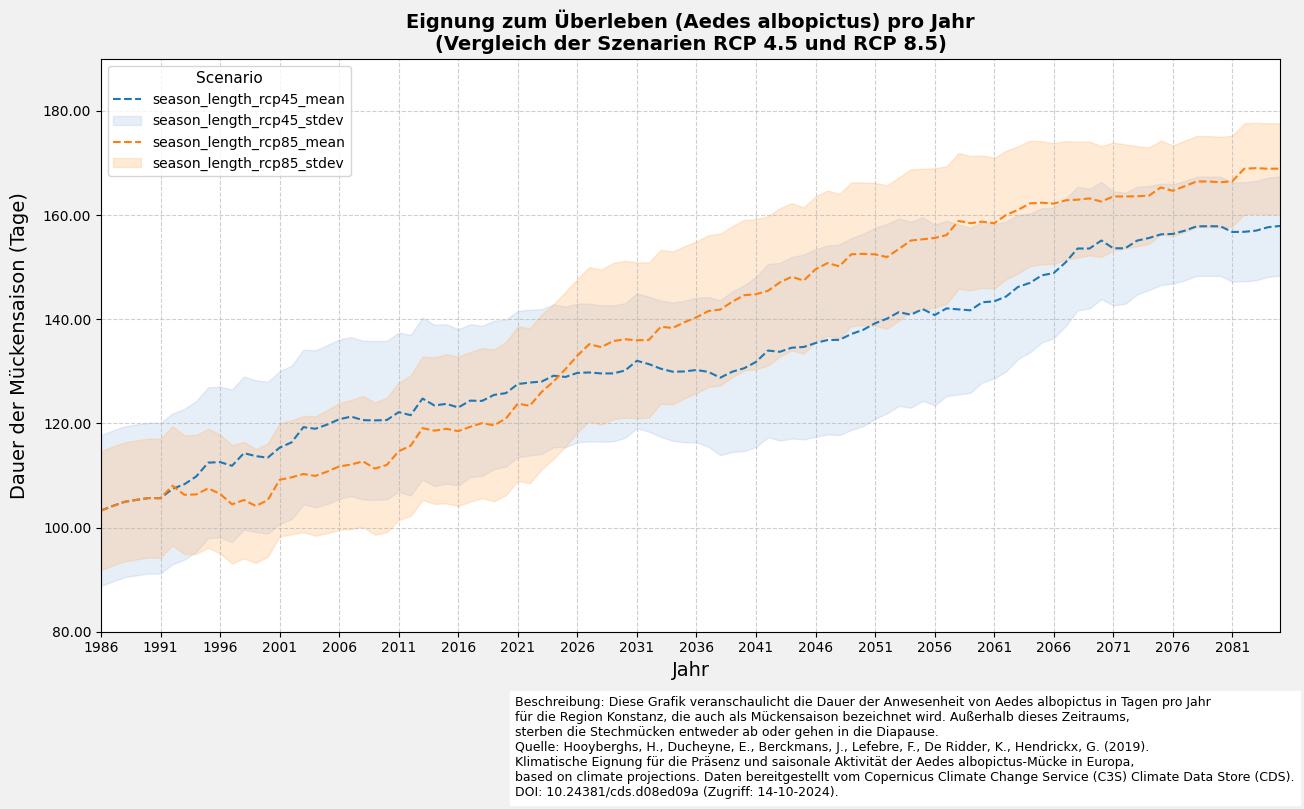

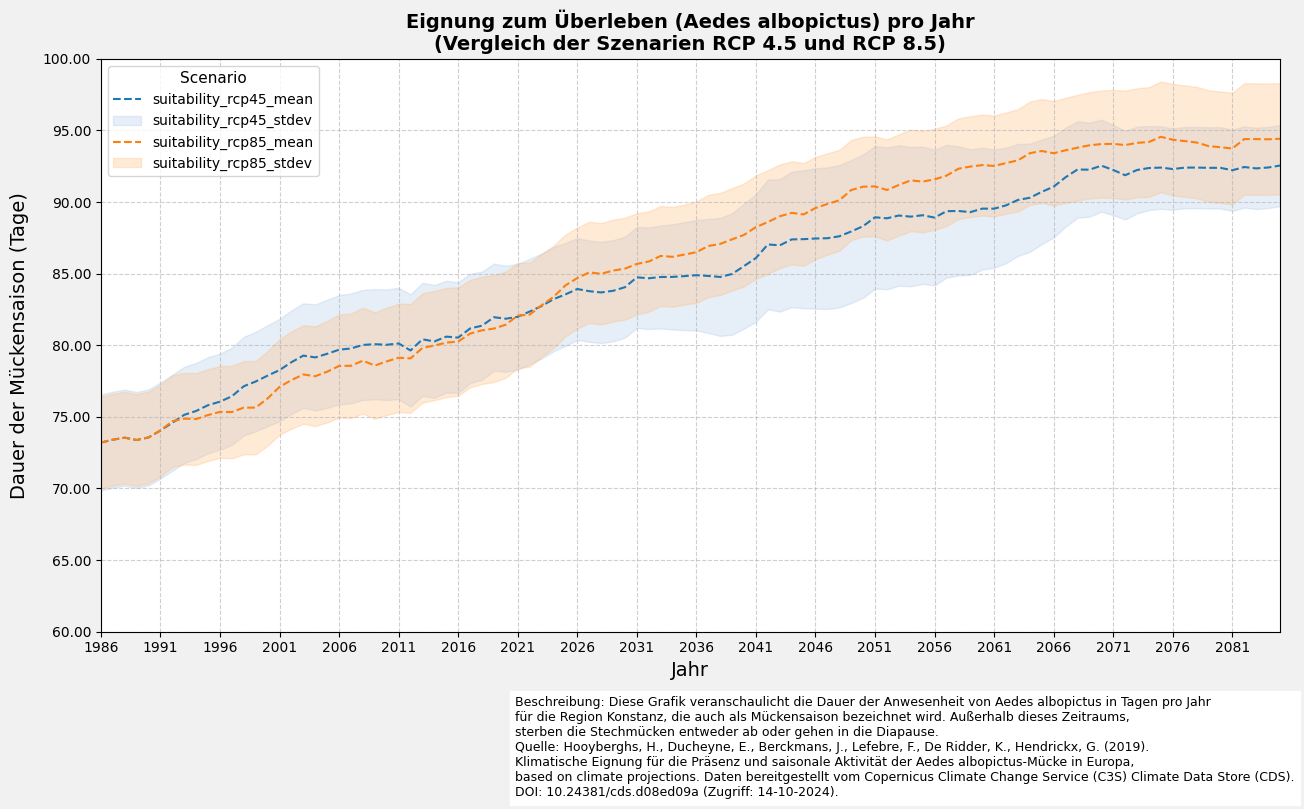

In [18]:
if __name__ == "__main__":
    # Beispiel für einen Anwendungsfall
    plot_mosquito_season(filtered_df_average=filtered_df_average,
                         variable_name='season_length')
    
    plot_mosquito_season(filtered_df_average=filtered_df_average,
                         variable_name='suitability')

### 6.5 Definieren eine Funktion zur Erstellung einer Heatmap

In [19]:
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import numpy as np

def main_plt_plot(
        nc_file=nc_file,
        selected_year=None,
        bounding_box=None):
    
    # Öffnet die NetCDF-Datei
    nc_dataset = nc.Dataset(nc_file['path'], mode='r')
    lat = nc_dataset.variables['lat'][:]
    lon = nc_dataset.variables['lon'][:]

    # Falls eine Begrenzungsbox angegeben wurde, filtere die Daten entsprechend
    if bounding_box:
        lat_indices = np.where((lat >= bounding_box[1]) & (lat <= bounding_box[3]))[0]
        lon_indices = np.where((lon >= bounding_box[0]) & (lon <= bounding_box[2]))[0]

        lat_subset = lat[lat_indices]
        lon_subset = lon[lon_indices]
    else:
        lat_indices = slice(None)
        lon_indices = slice(None)

        lat_subset = lat
        lon_subset = lon

    # Extrahiere Variablen-Daten
    variable_name = nc_file['variable_name']
    variable_data = nc_dataset.variables[variable_name][..., lat_indices, lon_indices]
    var_units = getattr(nc_dataset.variables[variable_name], "units", "N/A")

    # Bestimmen Sie den Jahresindex auf der Grundlage von selected_year.
    if selected_year < 1986:
        year_index = 0
        year = 1985
    elif selected_year > 2085:
        year_index = -1
        year = 2085
    else:
        year_index = selected_year-1986
        year = selected_year

    # Extrahieren Sie die Daten für das ausgewählte Jahr.
    band_data = variable_data[year_index]

    # NaN-Werte für Perzentilberechnungen entfernen
    band_data_nonan = band_data[~np.isnan(band_data)]
    vmin = np.nanpercentile(band_data_nonan, 1)
    vmax = np.nanpercentile(band_data_nonan, 99)

    def dynamic_round(value):
        # Bestimmen Sie die Größe des Wertes.
        order_of_magnitude = np.floor(np.log10(abs(value)))
        
        # Verwenden Sie diese Größe, um die Genauigkeit dynamisch zu wählen.
        if order_of_magnitude < -2:  # Werte kleiner als 0,01
            return round(value, 3)
        elif order_of_magnitude < -1:  # Werte zwischen 0,01 und 1
            return round(value, 2)
        elif order_of_magnitude < 0:  # Werte zwischen 1 und 10
            return round(value, 1)
        else:  # Werte 10 oder größer
            return round(value)
    
    # Dynamische Rundung auf vmin und vmax anwenden
    vmin = dynamic_round(vmin)
    vmax = dynamic_round(vmax)

    bins = 10
    interval = (vmax - vmin) / bins
    
    # Erstellen Sie ein 2D-Netzgitter für die grafische Darstellung.
    lon_grid, lat_grid = np.meshgrid(lon_subset, lat_subset)

    # Erstelle die Figur
    fig, ax = plt.subplots(
        figsize=(12, 8),
        facecolor='#f1f1f1',
        edgecolor='k',
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # Kartenmerkmale hinzufügen
    ax.coastlines(edgecolor='black', linewidth=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1.5)

    # Erstellen Sie ein Farbnetzdiagramm mit der angegebenen Farbkarte und den Grenzen.
    cmap = plt.get_cmap("viridis", bins)
    pcm = ax.pcolormesh(
        lon_grid,
        lat_grid,
        band_data,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        shading='auto',
        vmin=vmin,
        vmax=vmax,
        )
    
    # Einen Farbbalken hinzufügen
    ticks = np.linspace(vmin, vmax, num=bins + 1)
    cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.02, ticks=ticks)
    cbar.set_label(f"{variable_name}", fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    
    # Gitterlinien hinzufügen
    gl = ax.gridlines(draw_labels=True,
                      crs=ccrs.PlateCarree(),
                      linewidth=0.8,
                      color='gray',
                      alpha=0.7,
                      linestyle='--')
    gl.top_labels = False 
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    
    # Titel und Beschriftungen hinzufügen
    fig.text(0.5, 0.0, 'Longitude', ha='center', fontsize=14)
    fig.text(0.06, 0.5, 'Latitude', va='center', rotation='vertical', fontsize=14)
    ax.set_aspect("equal")

    # Einen Titel hinzufügen
    ax.set_title(f"{variable_name}, {year}", fontsize=14)

    # Layout anpassen und das Diagramm anzeigen
    plt.tight_layout()
    plt.show()

### 6.6 Visualisierung mit Heatmap

C:\Users\ShaileshShrestha\anaconda3\envs\cds_env\lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\ShaileshShrestha\AppData\Local\Temp\ipykernel_20664\4219951868.py:56: RuntimeWarning: divide by zero encountered in log10
  order_of_magnitude = np.floor(np.log10(abs(value)))


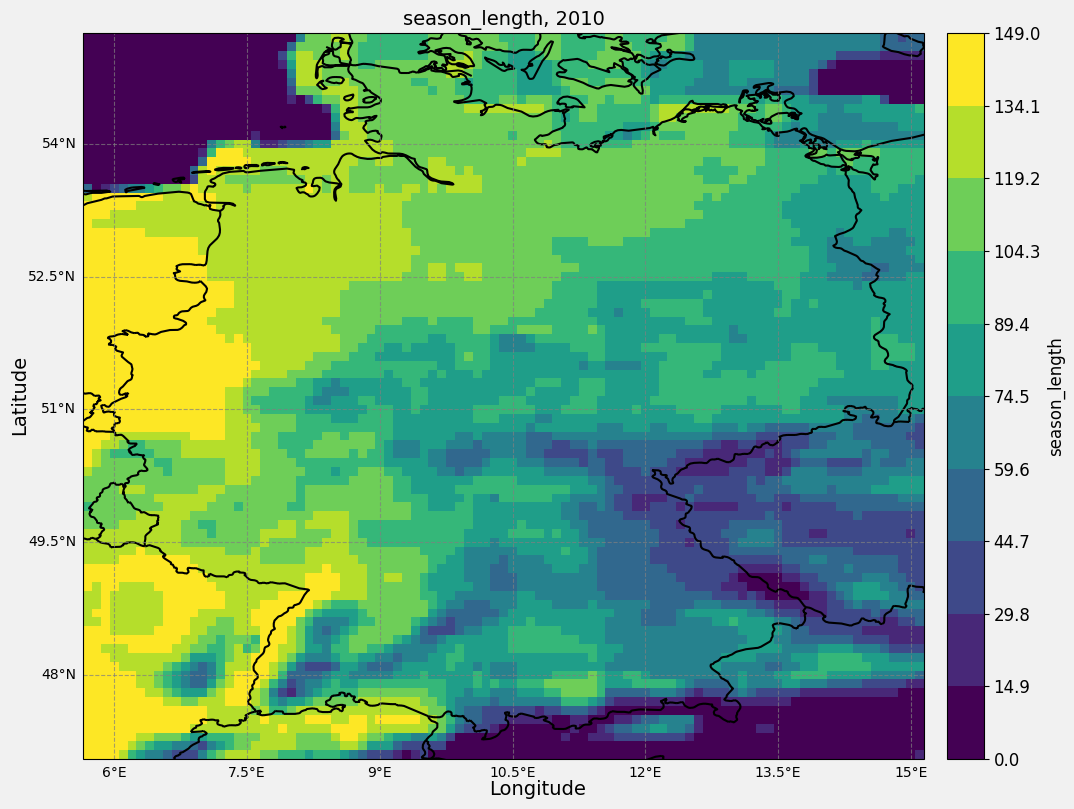

C:\Users\ShaileshShrestha\anaconda3\envs\cds_env\lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


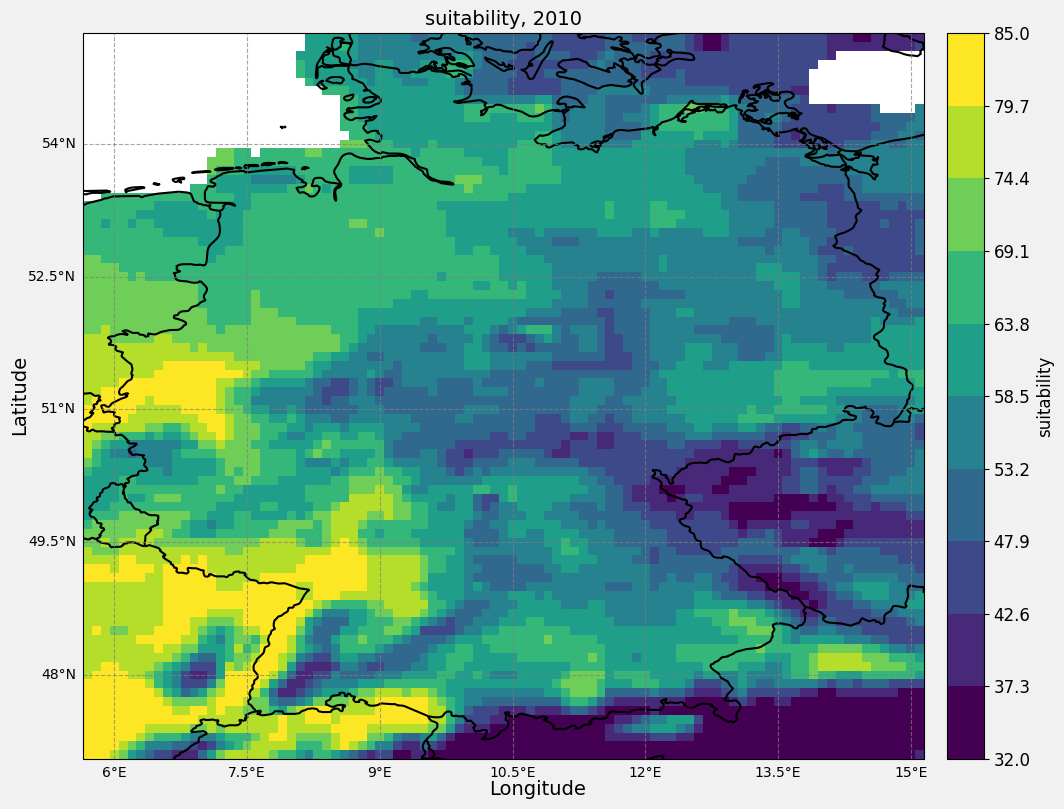

In [20]:
if __name__ == "__main__":
    # Beispiel für einen Anwendungsfall
    main_plt_plot(nc_file=nc_files[0],
                  selected_year=2010,
                  )

    main_plt_plot(nc_file=nc_files[4],
                  selected_year=2010,
                  )